In [58]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('AMZN.csv')

#print the head
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-04-03,69.569000,70.699997,67.766502,69.602501,69.602501,204624000
1,2018-04-04,67.912003,70.769501,67.643997,70.528503,70.528503,139646000
2,2018-04-05,72.099503,72.977997,71.353500,72.587502,72.587502,128270000
3,2018-04-06,71.498497,72.625000,70.013000,70.261497,70.261497,117646000
4,2018-04-09,71.251503,71.924004,70.128502,70.304001,70.304001,84164000


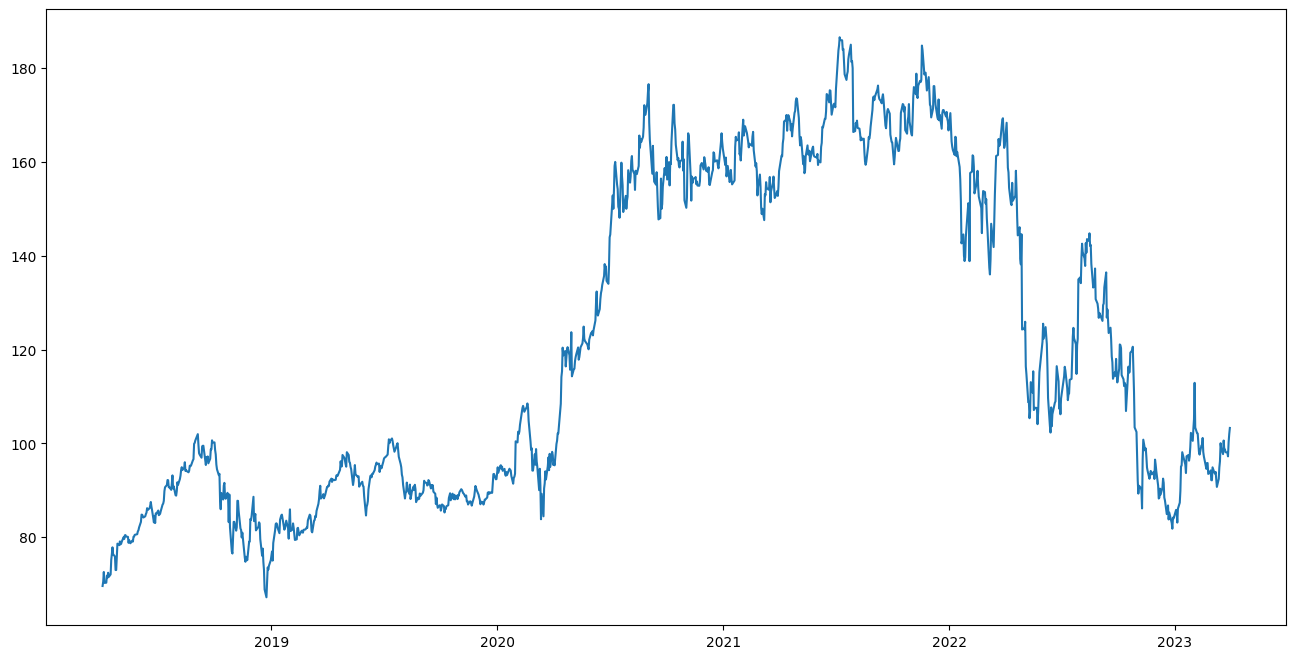

In [59]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

MOVING AVERAGES METHOD

In [60]:
#creating dataframe with date and the target variable
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
     new_data['Date'][i] = data['Date'][i]
     new_data['Close'][i] = data['Close'][i]

In [61]:
#splitting into train and validation
train = new_data[:987]
valid = new_data[987:]

In [62]:
new_data.shape, train.shape, valid.shape
((1235, 2), (987, 2), (248, 2))

((1235, 2), (987, 2), (248, 2))

In [63]:
train['Date'].min(), train['Date'].max(), valid['Date'].min(), valid['Date'].max()


(Timestamp('2018-04-03 00:00:00'),
 Timestamp('2022-03-02 00:00:00'),
 Timestamp('2022-03-03 00:00:00'),
 Timestamp('2023-03-31 00:00:00'))

In [64]:
#make predictions
preds = []
for i in range(0,272):
    a = train['Close'][len(train)-272+i:].sum() + sum(preds)
    b = a/272
    preds.append(b)

In [65]:
#calculate rmse
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-preds),2)))
rms

55.38788772541641

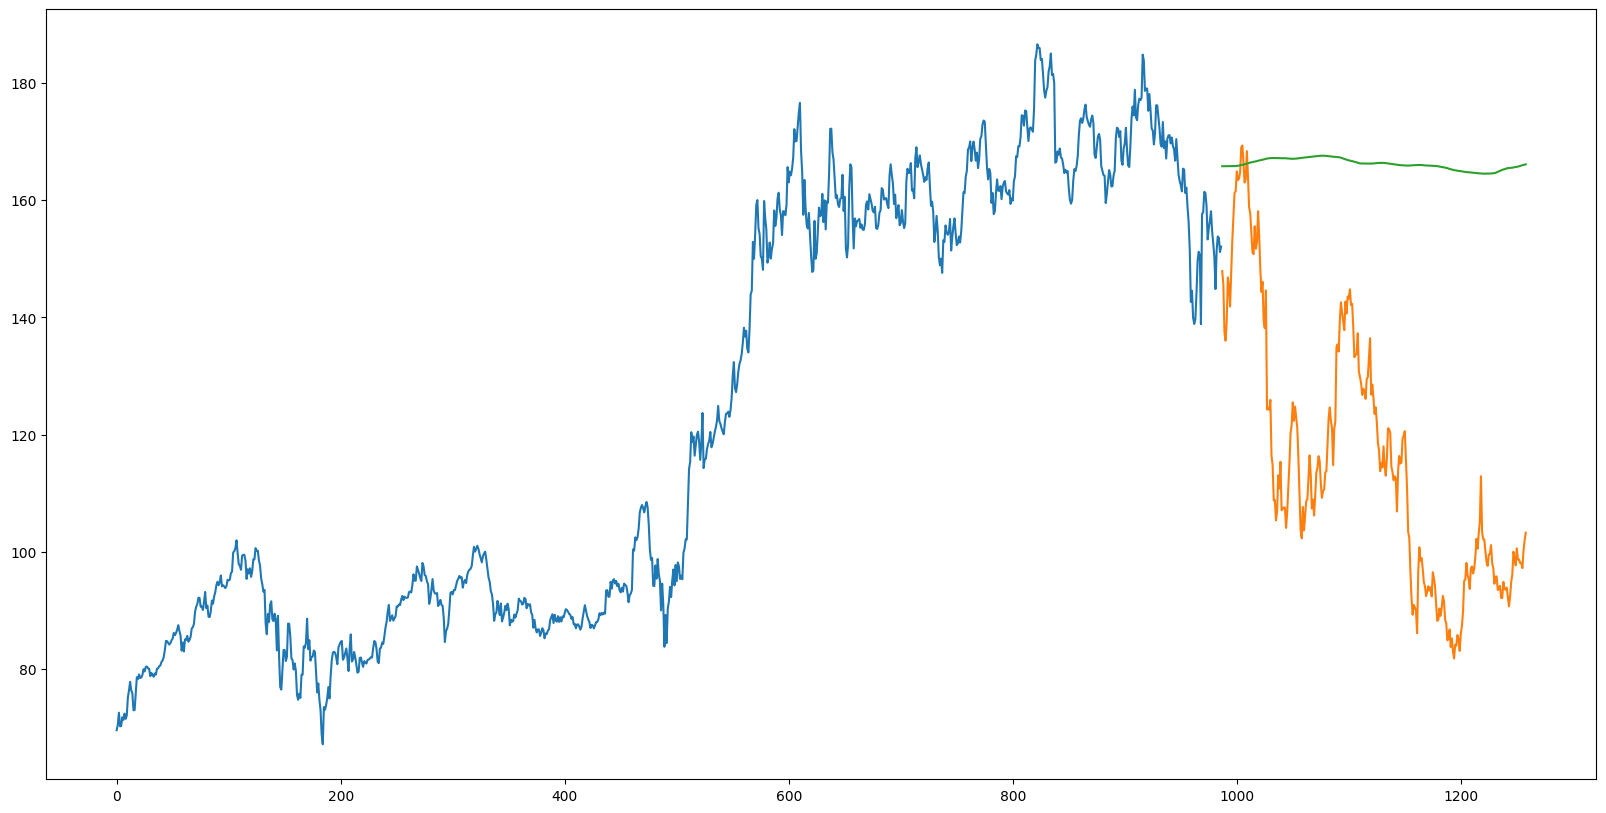

In [66]:
#plot
# valid['Predictions'] = 0
# valid['Predictions'] = preds
# plt.plot(train['Close'])
# plt.plot(valid[['Close', 'Predictions']])

# Create a copy of valid to avoid SettingWithCopyWarning
valid_copy = valid.copy()

# Set Predictions column to zero for all rows in valid_copy
valid_copy['Predictions'] = 0

# Assign the predicted values to the Predictions column
valid_copy.loc[:, 'Predictions'] = preds

# Set the index for valid_copy and train to the appropriate rows in new_data
valid_copy.index = new_data[987:].index
train.index = new_data[:987].index

# Plot the training data and predicted values
plt.plot(train['Close'])
plt.plot(valid_copy[['Close', 'Predictions']])

LINEAR REGRESSION

In [67]:
#setting index as date values
df['Date'] = pd.to_datetime(df.Date,format='%d-%m-%Y')
df.index = df['Date']

#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

In [68]:
!pip install torch
!pip install fastai==0.7.0 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached fastai-0.7.0-py3-none-any.whl (112 kB)
  Using cached jedi-0.18.2-py2.py3-none-any.whl (1.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.9/83.9 kB 10.2 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement torch<0.4 (from fastai) (from versions: 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0)
ERROR: No matching distribution found for torch<0.4


In [69]:
#create features
from fastai.tabular.core import add_datepart
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp

In [70]:
new_data['mon_fri'] = 0
for i in range(0,len(new_data)):
    if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
        new_data.loc[i, 'mon_fri'] = 1
    else:
        new_data.loc[i, 'mon_fri'] = 0

In [71]:
#split into train and validation
train = new_data[:987]
valid = new_data[987:]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [72]:
#make predictions and find the rmse
preds = model.predict(x_valid)

import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Define a function to compute the performance metrics
def evaluate_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2


# Compute the performance metrics using the function above
mse, rmse, r2 = evaluate_performance(y_valid, preds)

# Print the results
print("MSE: {:.4f}".format(mse))
print("RMSE: {:.4f}".format(rmse))
print("R2 Score: {:.4f}".format(r2))

rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

MSE: 7552.4349
RMSE: 86.9047
R2 Score: -14.8459


86.90474615850393

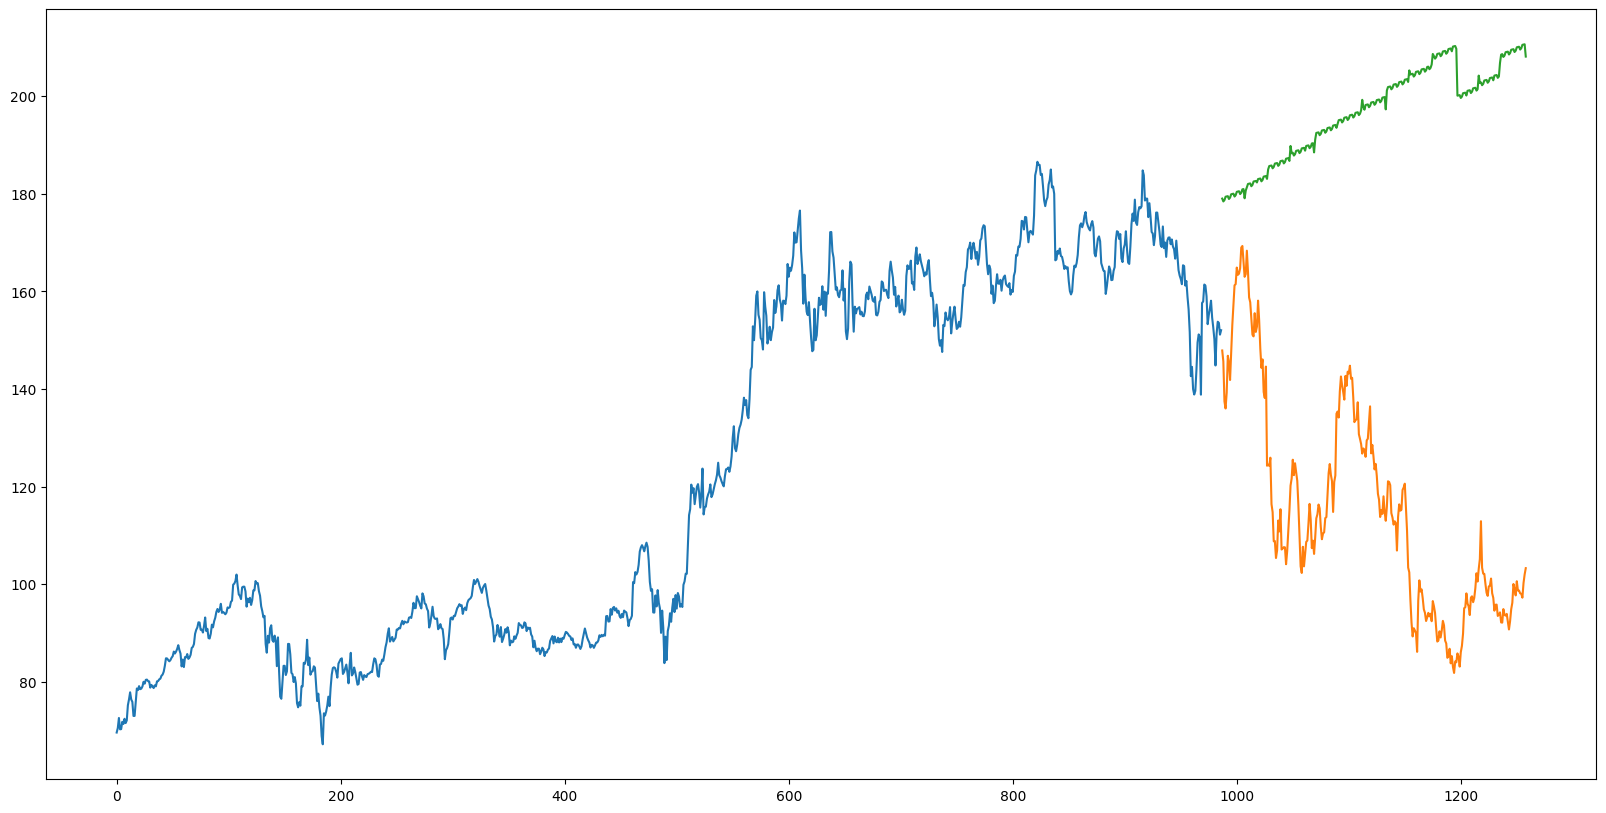

In [73]:
# #plot
# valid['Predictions'] = 0
# valid['Predictions'] = preds

# valid.index = new_data[987:].index
# train.index = new_data[:987].index

# plt.plot(train['Close'])
# plt.plot(valid[['Close', 'Predictions']])


# Create a copy of valid to avoid SettingWithCopyWarning
valid_copy = valid.copy()

# Set Predictions column to zero for all rows in valid_copy
valid_copy['Predictions'] = 0

# Assign the predicted values to the Predictions column
valid_copy.loc[:, 'Predictions'] = preds

# Set the index for valid_copy and train to the appropriate rows in new_data
valid_copy.index = new_data[987:].index
train.index = new_data[:987].index

# Plot the training data and predicted values
plt.plot(train['Close'])
plt.plot(valid_copy[['Close', 'Predictions']])

K NEAREST NEIGHBOR

In [74]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [75]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

In [76]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Define a function to compute the performance metrics
def evaluate_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2


# Compute the performance metrics using the function above
mse, rmse, r2 = evaluate_performance(y_valid, preds)

# Print the results
print("MSE: {:.4f}".format(mse))
print("RMSE: {:.4f}".format(rmse))
print("R2 Score: {:.4f}".format(r2))

#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

MSE: 2223.1423
RMSE: 47.1502
R2 Score: -3.6644


47.15020946150077

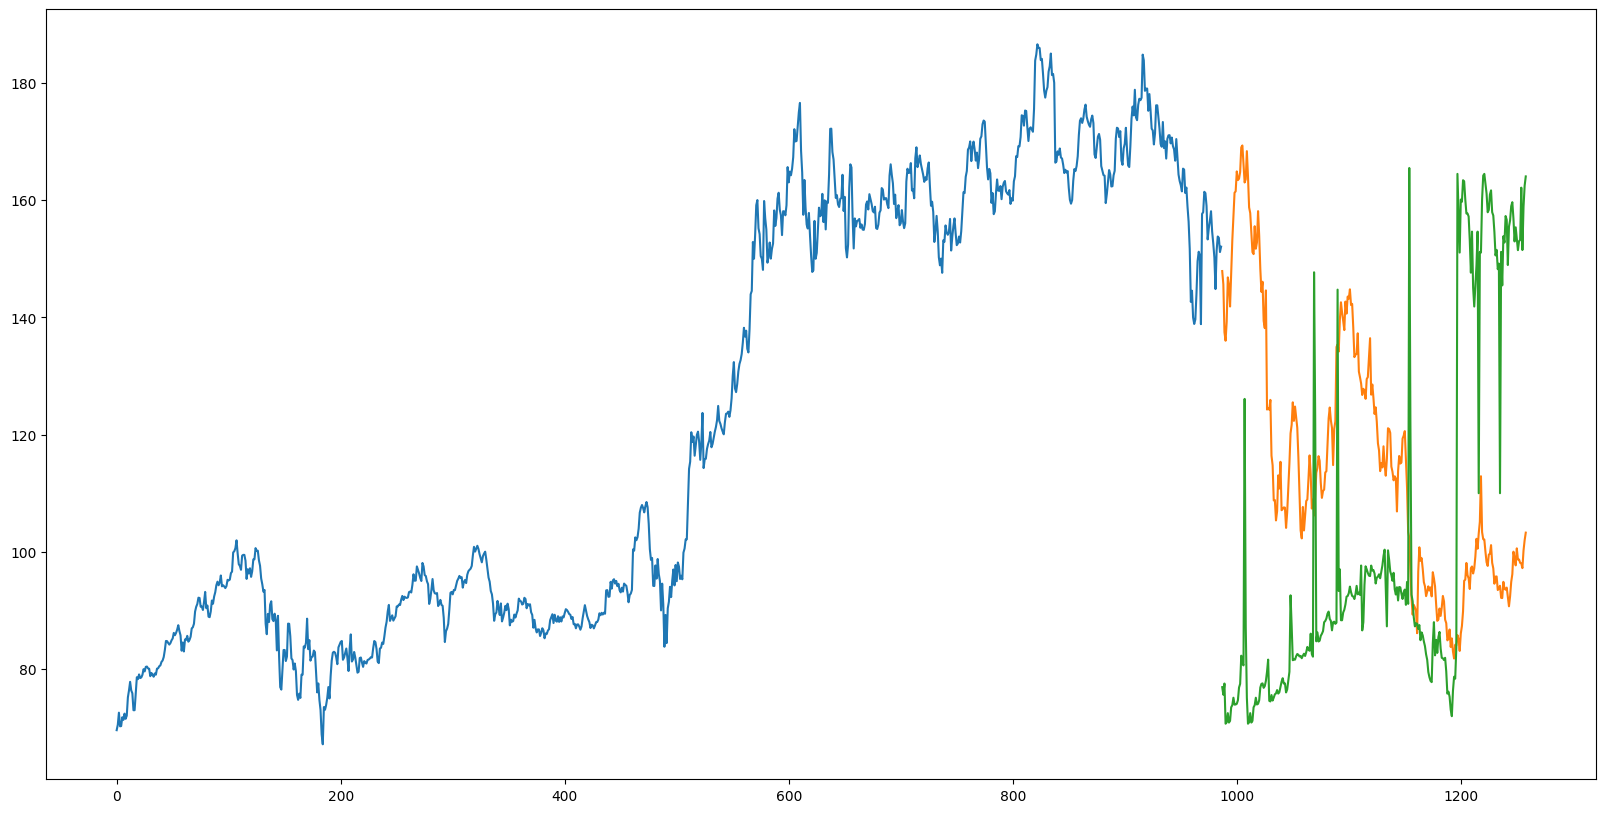

In [77]:
# #plot
# valid['Predictions'] = 0
# valid['Predictions'] = preds
# plt.plot(valid[['Close', 'Predictions']])
# plt.plot(train['Close'])

# Create a copy of valid to avoid SettingWithCopyWarning
valid_copy = valid.copy()

# Set Predictions column to zero for all rows in valid_copy
valid_copy['Predictions'] = 0

# Assign the predicted values to the Predictions column
valid_copy.loc[:, 'Predictions'] = preds

# Set the index for valid_copy and train to the appropriate rows in new_data
valid_copy.index = new_data[987:].index
train.index = new_data[:987].index

# Plot the training data and predicted values
plt.plot(train['Close'])
plt.plot(valid_copy[['Close', 'Predictions']])

ARIMA

In [78]:
# !pip install pyramid.arima
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
# from pyramid.arima import auto_arima
from pmdarima.arima import auto_arima

data = df.sort_index(ascending=True, axis=0)

train = data[:987]
valid = data[987:]

training = train['Close']
validation = valid['Close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=272)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=4.51 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5225.499, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4955.300, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.79 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5225.156, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4786.918, Time=1.44 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=12.49 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.74 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4787.526, Time=2.38 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4787.226, Time=2.58 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=4783.514, Time=5.70 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=4952.216, Time=3.33 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=17.69 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.22 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=4787

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [81]:
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
rms

nan

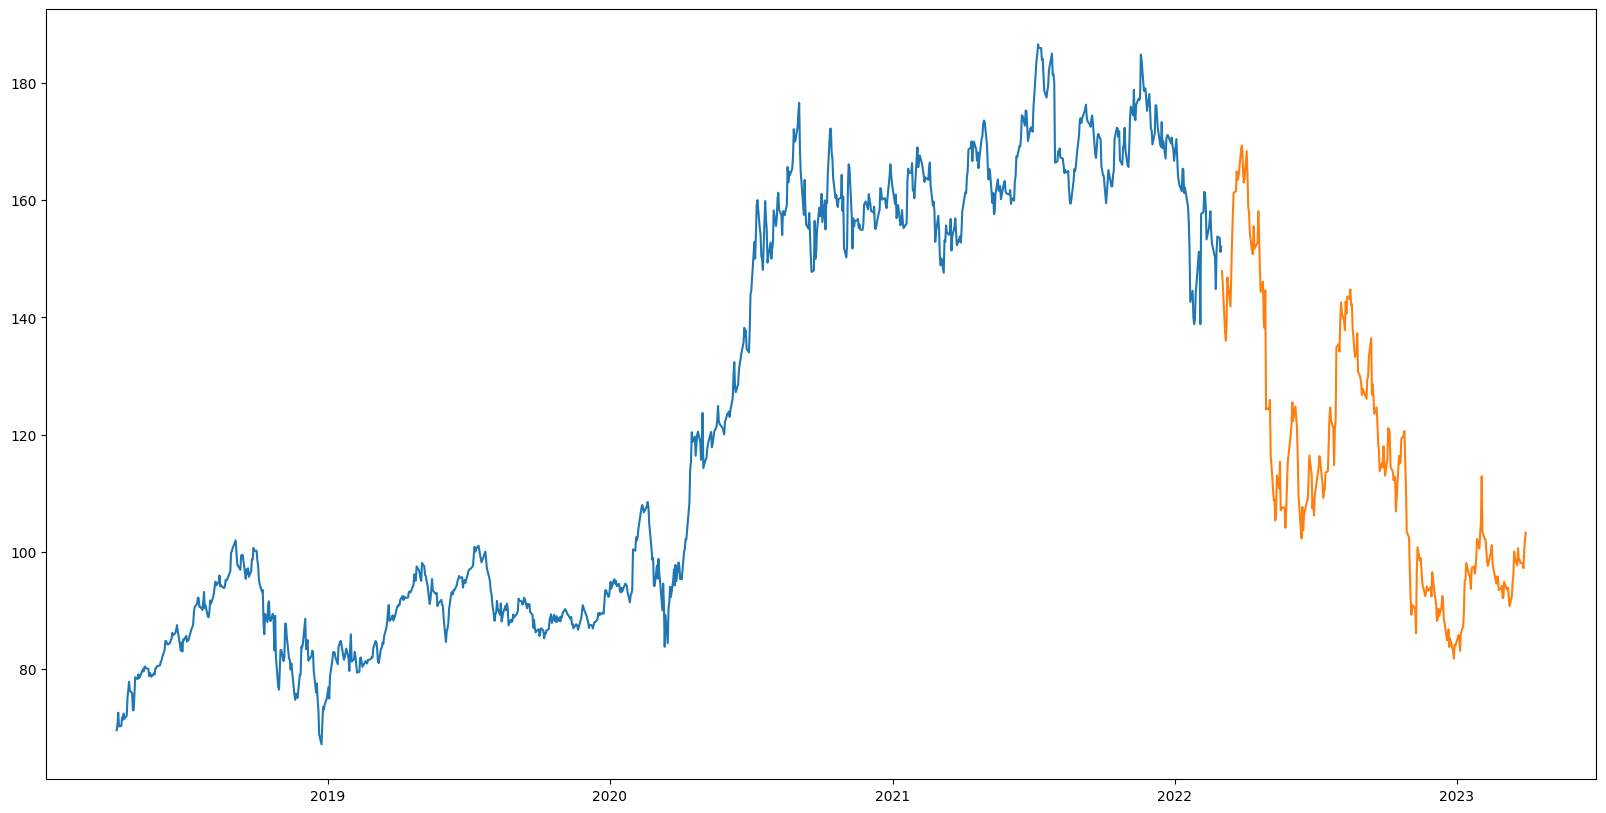

In [82]:
#plot
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction'])

LSTM

In [83]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
# Predict the future stock prices using your trained model
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

927/927 - 24s - loss: 0.0049 - 24s/epoch - 26ms/step
9/9 [==============================] - 1s 14ms/step


In [84]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Define a function to compute the performance metrics
def evaluate_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2


# Compute the performance metrics using the function above
mse, rmse, r2 = evaluate_performance(valid, closing_price)

# Print the results
print("MSE: {:.4f}".format(mse))
print("RMSE: {:.4f}".format(rmse))
print("R2 Score: {:.4f}".format(r2))

rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

MSE: 214.4723
RMSE: 14.6449
R2 Score: 0.5500


14.644873391381292

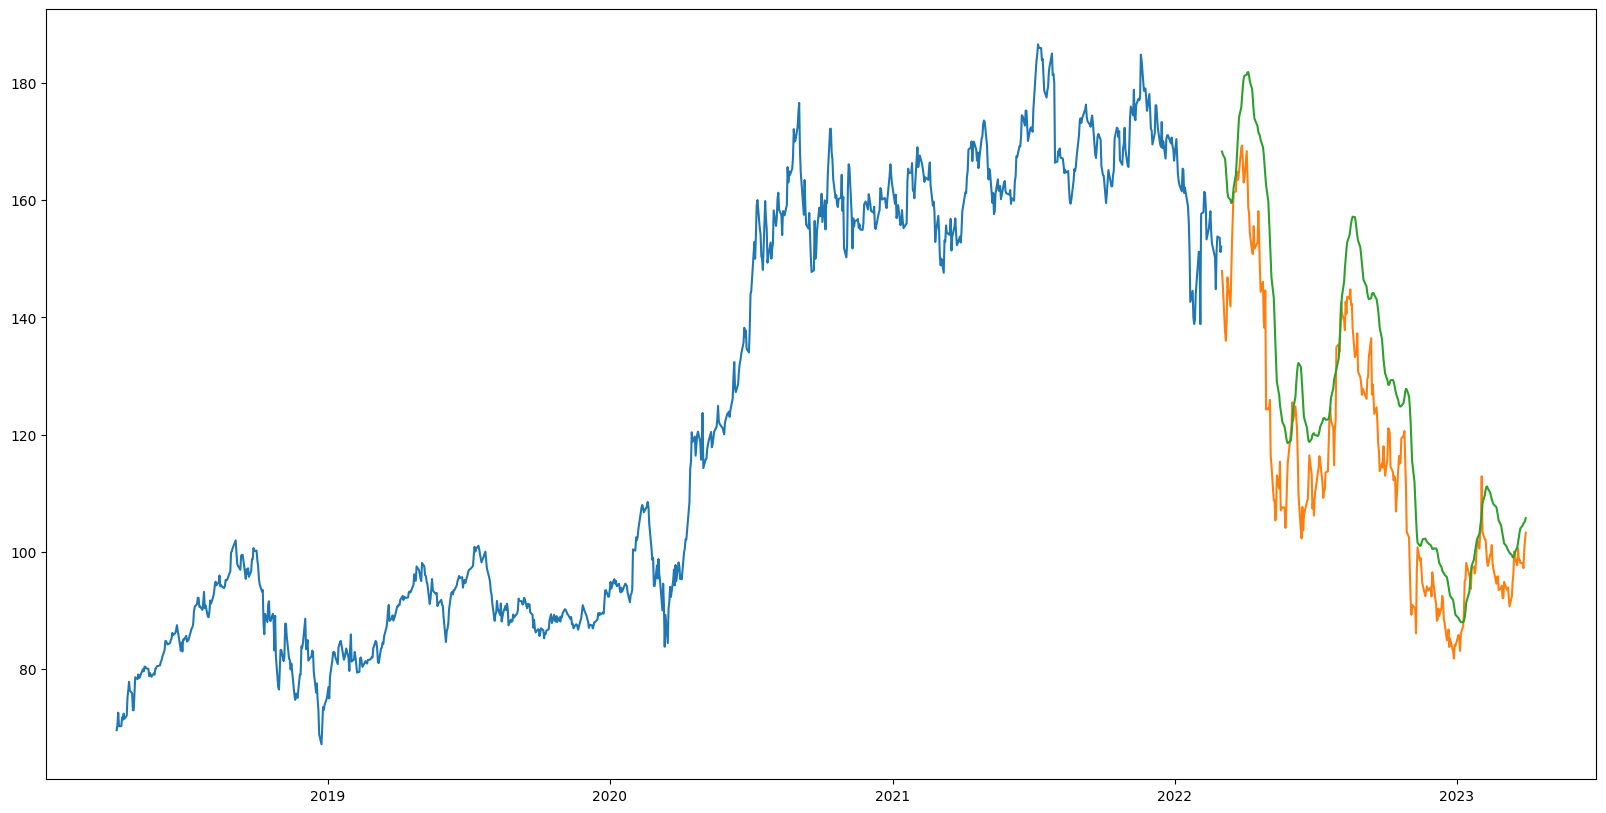

In [85]:
#for plotting
train = new_data[:987]
valid = new_data[987:].copy()
valid.loc[:, 'Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])